# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
def estudio_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()
    plt.title('STL')
    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

        
    plt.xticks(rotation=90)
    
    plt.show()
    
def realizar_diferenciacion(df, variable, n_diff):
    for i in range(0, n_diff):
        df[variable] = df[variable].diff().dropna()
    
    return df
    
    
def visualizar_diferencia(df):

    plt.figure(figsize=(10, 6))
    plt.plot(df['fecha'], df['numero_casos'])
    plt.title('Transformación por diferencia de la serie temporal')
    plt.xlabel('Fecha')
    plt.ylabel('Diferencia')
    
    
    plt.show()
    
def visualizar_acf(df, variable, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df[variable], lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, variable, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df[variable], lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    plt.figure(figsize=(10, 6))

    plt.plot(test.index, test[variable], label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')


    plt.xticks(rotation=90)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()

def visualizar_pred(train, test, pred, variable, tit):
        plt.figure(figsize=(10, 6))

        plt.plot(test.index, test[variable], label='Test', color='green')
        plt.plot(test.index, pred, label='Predicción', color='orange')
    
    
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(tit)
        plt.xlabel('Fecha')
        plt.ylabel('Número de casos de COVID')
        plt.show()
    
def obtener_errores(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse


    
def winsorizacion(df, variable):
    
    percentil_5 = df[variable].quantile(0.05)
    print(percentil_5)
    percentil_95 = df[variable].quantile(0.95)
    print(percentil_95)
    
    df[variable] = np.where(df[variable] < percentil_5, percentil_5,
                               np.where(df[variable] > percentil_95, percentil_95, df[variable]))
    
    return df

In [34]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

In [35]:
datos_tenerife = datos[datos['isla'] == 'TENERIFE'].copy()
datos_tenerife_arima = datos_tenerife[['fecha', 'numero_casos']]
datos_tenerife_arima.set_index('fecha', inplace=True)

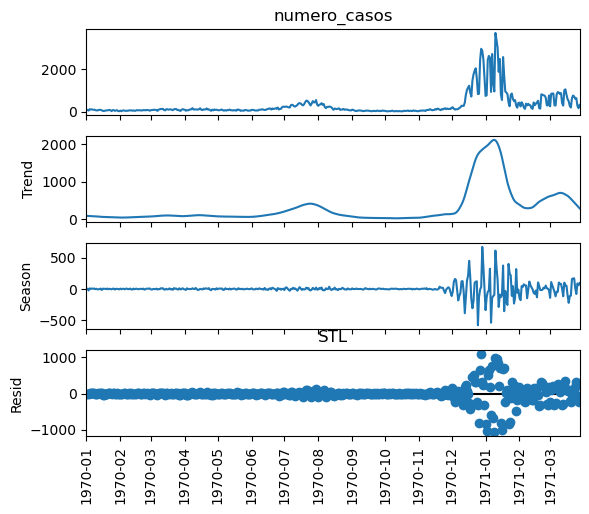

In [36]:
estudio_STL(datos_tenerife_arima['numero_casos'])

Realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

Esta prueba de 

In [ ]:
adf_tenerife = adfuller(datos_tenerife_arima['numero_casos'])
print("ADF p-value:" + str(adf_tenerife[1]))

Podemos observar que el p valor es inferior al valor de significancia 0.05 por lo que la serie temporal ya es estacionaria y por lo tanto el valor d del modelo ARIMA es 0

Realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de p

<Figure size 1600x1000 with 0 Axes>

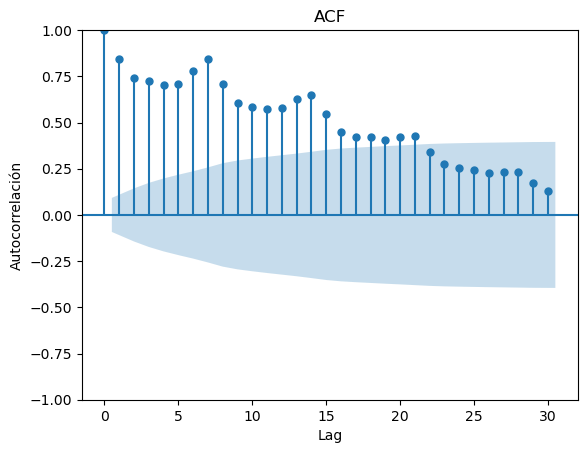

In [8]:
visualizar_acf(datos_tenerife_arima, 'numero_casos', 30)

Realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de q

<Figure size 1600x600 with 0 Axes>

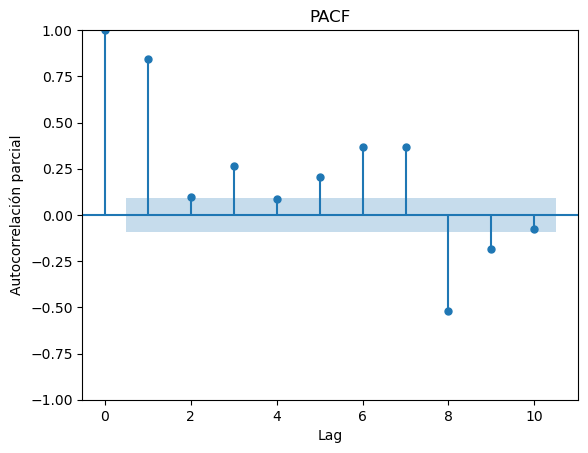

In [9]:
visualizar_pacf(datos_tenerife_arima, 'numero_casos', 10)

# Modelo ARIMA univariable

In [37]:
datos_arima_tenerife = datos_tenerife_arima.copy()

n_dias = 10

train = datos_arima_tenerife.iloc[:len(datos_arima_tenerife) - n_dias]
test =  datos_arima_tenerife.iloc[len(datos_arima_tenerife) - n_dias:]

objetivo = 'numero_casos'

In [63]:
#order=(p,d,q)
# Parámetros del modelo ARIMA
p = 3
d = 0
q = 7

arima_tenerife = ARIMA(endog=train[objetivo], order=(p, d, q), freq = 'D')
model_arima_tenerife = arima_tenerife.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
pred = model_arima_tenerife.forecast(steps=10)

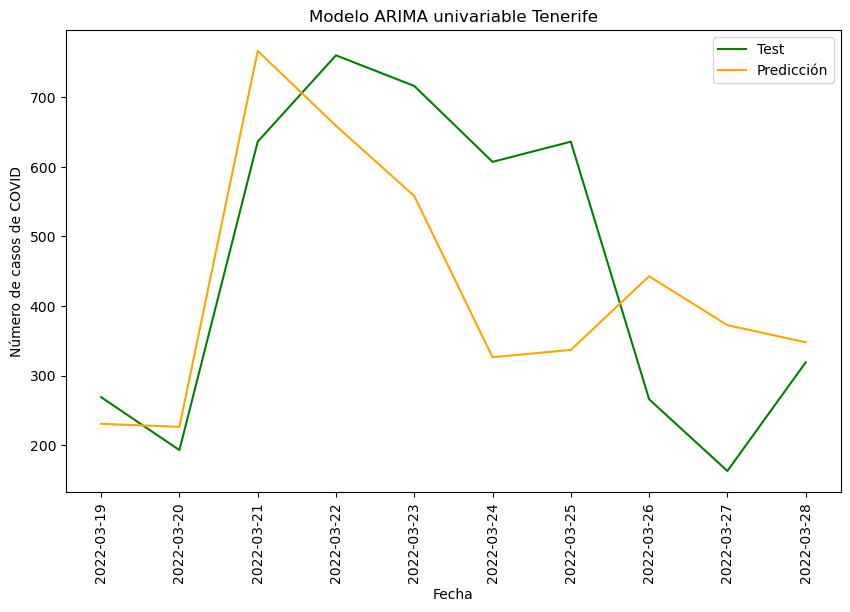

In [65]:
visualizar_dif_pred_test(test, pred, objetivo, 'Modelo ARIMA univariable Tenerife')

Para la evaluación del modelo se utilizará:
* MAE:
* MSE:
* RMSE:

In [66]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

In [67]:
print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 29883.390414607547
Error absoluto medio (MAE) del modelo: 145.57892438023
Raíz del error cuadrático medio (RMSE) del modelo: 172.8681301298986


# Modelo ARIMA multivariable

In [17]:
datos_tenerife = datos[datos['isla'] == 'TENERIFE'].copy()

variables_covid = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']

datos_tenerife_arima = datos_tenerife[['fecha', objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_tenerife_arima.set_index('fecha', inplace=True)

In [18]:
n_dias = 10

train = datos_tenerife_arima.iloc[:len(datos_tenerife_arima) - n_dias]
test =  datos_tenerife_arima.iloc[len(datos_tenerife_arima) - n_dias:]

In [19]:
#order=(p,d,q)
# Parámetros del modelo ARIMA
p = 18
d = 0
q = 3

arima_tenerife = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
model_arima_tenerife = arima_tenerife.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
pred = model_arima_tenerife.forecast(steps=10, exog=test[variables_covid])

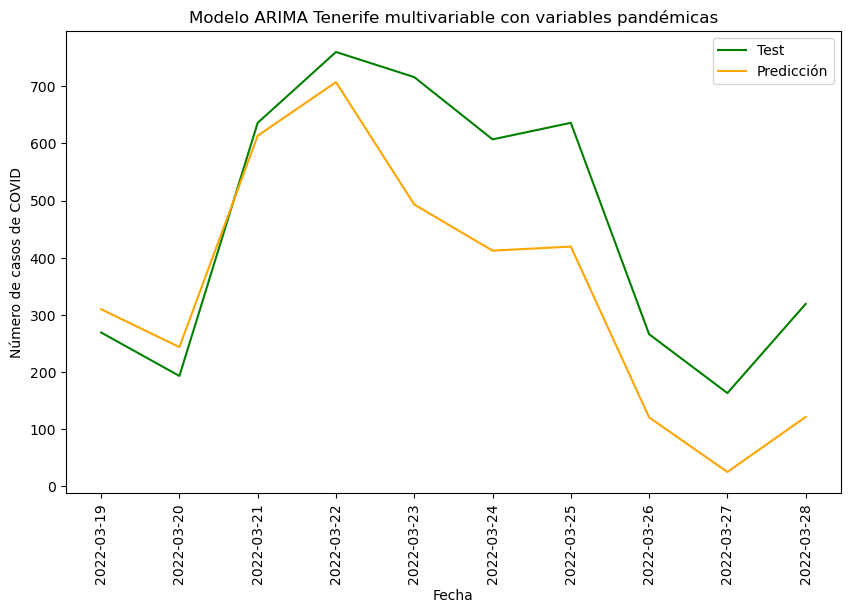

In [21]:
visualizar_dif_pred_test(test, pred, objetivo, 'Modelo ARIMA Tenerife multivariable con variables pandémicas')

In [24]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

NameError: name 'rsme' is not defined

In [ ]:
print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))